## Design of Experiments to optimize perovskite solar cells efficiency

This notebook is made to use BOAR for experimental design. Here, we show how to load some data from a presampling, and how to use BOAR to suggest the next set of experiment using Bayesian optimization.
The goal here is to optimize the processing conditions for a perovskite solar cell to maximize the power conversion efficiency (PCE).

Note: The data used here is real data generated in the [i-MEET](https://www.i-meet.ww.uni-erlangen.de/) and [HI-ERN](https://www.hi-ern.de/de) labs at the university of Erlangen-Nuremberg (FAU) by Jiyun Zhang for the paper: 'Autonomous Optimization of Air-Processed Perovskite Solar Cell in a 6D Parameter Space'


In [1]:
# Activate matplotlib widgets
%matplotlib inline
%matplotlib widget 
# import plotly.io as pio # comment out to only render png
# pio.renderers.default = 'png'

# Import libraries
import sys,os,types,copy
import warnings
import pandas as pd
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar libraries
from boar import *
from boar.core.optimization_botorch import *
import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings (can be commented out to use default matplotlib settings)
# # import additional libraries from Ax
import ax
from ax.utils.notebook.plotting import render# for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted 
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation


In [2]:
# Define the path to the data 
curr_dir = os.getcwd() # current directory
res_dir = os.path.join(curr_dir,'temp') # path to the results directory
data_dir =os.path.join(os.path.abspath(curr_dir),'Final_data') # path to the data directory

In [3]:
# Load the data from Round 1 to 4 and append to same dataframe
df = pd.read_csv(os.path.join(data_dir,'Round1.csv'),sep='\s+')

# select the number of rounds to include
num_rounds = 4 # can be 1,2,3 or 4
if num_rounds > 4:
    raise ValueError('The number of rounds cannot exceed 4')
if num_rounds <= 4:
    for i in range(2,min(num_rounds+1,4)): # Do not include 4 as it contains repeated data
        df = pd.concat([df,pd.read_csv(os.path.join(data_dir,f'Round{i}.csv'),sep='\s+')])
df = df.reset_index(drop=True)
df['Rshunt'] = np.log10(df['Rshunt'])
df['Rseries'] = np.log10(df['Rseries'])

print(df.describe())

       Spin_Speed_1  Duration_t1  Spin_Speed_2  Dispense_Speed  Duration_t3  \
count     68.000000    68.000000     68.000000       68.000000    68.000000   
mean    1532.619118    18.899853   2261.959118      231.266471    17.511324   
std      470.417248     7.072611    519.160899       86.069826     7.736712   
min      540.030000     5.000000   1021.640000       16.030000     5.000000   
25%     1217.500000    14.240000   1952.922500      196.250000    11.532500   
50%     1514.000000    18.380000   2385.915000      247.715000    17.000000   
75%     1801.417500    22.230000   2668.750000      277.717500    23.390000   
max     2579.000000    34.340000   3000.000000      396.430000    35.000000   

       Spin_Speed_3        Jsc        Voc         FF       Pmax       Vmpp  \
count     68.000000  68.000000  68.000000  68.000000  68.000000  68.000000   
mean    3751.422647  24.247235   1.010793   0.719228  17.895353   0.813588   
std      891.697952   1.928808   0.108510   0.055736  

In [4]:
params_names = ['Spin_Speed_1', 'Duration_t1', 'Spin_Speed_2', 'Dispense_Speed',
       'Duration_t3', 'Spin_Speed_3']

y_dimension = 'Pmax'
y_unit = 'mW cm$^{-2}$'
target_names = [y_dimension]
df_filtered = copy.deepcopy(df[params_names+target_names])
df_filtered = df_filtered.drop_duplicates()
df_filtered = df_filtered.dropna()


dic = {'x':[],'y_0':[],'ydyn_0':1,'y_1':[],'ydyn_1':1}
for num in range(len(df_filtered)):
    dic['x'].append(df_filtered[params_names].iloc[num].values.tolist())
    dic['y_0'].append(df_filtered[target_names[0]].iloc[num])
    

# save to res_dir
with open(os.path.join(res_dir,'old_XY.json'), 'w') as fp:
    json.dump(dic, fp)



# Define the free parameters to be optimized

In [5]:
params = []

Spin_Speed_1 = Fitparam(name = 'Spin_Speed_1', val =  1000, lims = [500, 3000], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin Speed 1', unit = 'RPM',val_type='int',rescale=False)
params.append(Spin_Speed_1)
Duration_t1 = Fitparam(name = 'Duration_t1', val =  10, lims = [5, 35], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Duration t1', unit = 's',val_type='int'
                        ,rescale=False)
params.append(Duration_t1)
Spin_Speed_2 = Fitparam(name = 'Spin_Speed_2', val =  1000, lims = [1000, 3000], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin Speed 2', unit = 'RPM',val_type='int'
                        ,rescale=False)
params.append(Spin_Speed_2)
Dispense_Speed = Fitparam(name = 'Dispense_Speed', val =  100, lims = [10, 400], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Dispense Speed', unit = '',val_type='int'
                        ,rescale=False)
params.append(Dispense_Speed)
Duration_t3 = Fitparam(name = 'Duration_t3', val =  10, lims = [5, 35], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Duration t3', unit = 's',val_type='int'
                        ,rescale=False)
params.append(Duration_t3)
Spin_Speed_3 = Fitparam(name = 'Spin_Speed_3', val =  1000, lims = [2000, 5000], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin Speed 3', unit = 'RPM',val_type='int',rescale=False)
params.append(Spin_Speed_3)

# Start the optimization

In [6]:
# Define the number of new experiments to suggest
nb_new_exp = 18

def exp_to_df(X,params): # not really need here but we need to pass an argument to the target object
    pass
# Define the targets and the model for the TM problem
X_dimensions = ['_']

target = {'model':exp_to_df,'target_name':y_dimension,'minimize':False,
          'data':{'X':[0],'y':[0],'X_dimensions':X_dimensions,'X_units':['V',''],'y_dimension':y_dimension,'y_unit':y_unit}
            ,'target_weight':1, 'weight':1}


targets = [target]
obj_type='identity'
loss='linear'
threshold=[18]

mo = MooBOtorch(params=params, targets= targets) # initialize the optimization object
mo.warmstart = 'recall'
mo.parallel = False # needed if number of cores is lower than number of CPU - 1 to ensure we output the right number of points
# mo.SaveOldXY2file = os.path.join(res_dir,'old_XY.json')
mo.Path2OldXY = os.path.join(res_dir,'old_XY.json')
# mo.parameter_constraints = [f'{stepsize_fraction}*Cs_fraction + {stepsize_fraction}*Fa_fraction <= 1']

# Define custom evaluation function
def evaluate_custom(self,px,obj_type,loss,threshold=1,is_MOO=True):
  pass
  

mo.evaluate_custom = types.MethodType(evaluate_custom, mo) # add the method to the object FullyBayesianMOO
kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':None,'show_points':True,'savefig':False,'figname':'param_posterior','full_grid':True,'randomize':True}

ax_client = mo.BoTorchOpti(n_jobs=[nb_new_exp], n_step_points = [nb_new_exp], models=['FullyBayesian'],obj_type=obj_type,loss=loss,threshold=threshold,use_CUDA=True,is_MOO=False,verbose=True,show_posterior=False,kwargs_posterior=kwargs_posterior,use_custom_func=False,suggest_only=True)

model = ax_client.generation_strategy.model

[INFO 09-02 11:33:06] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 09-02 11:33:06] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Spin_Speed_1', parameter_type=INT, range=[500, 3000]), RangeParameter(name='Duration_t1', parameter_type=INT, range=[5, 35]), RangeParameter(name='Spin_Speed_2', parameter_type=INT, range=[1000, 3000]), RangeParameter(name='Dispense_Speed', parameter_type=INT, range=[10, 400]), RangeParameter(name='Duration_t3', parameter_type=INT, range=[5, 35]), RangeParameter(name='Spin_Speed_3', parameter_type=INT, range=[2000, 5000])], parameter_constraints=[]).
[INFO 09-02 11:33:06] ax.core.experiment: Attached custom parameterizations [{'Spin_Speed_1': 2404, 'Duration_t1': 15, 'Spin_Speed_2': 1745, 'Dispense_Speed': 203, 'Duration_t3': 13, 'Spin_Speed_3': 44

In [7]:
# Print the optimized stack structure
for p in mo.params:
    if p.val_type != 'str':
        print(p.display_name + f' {p.val:.0f} ')
        print(p.lims)
    else:
        print(p.display_name + f' {p.val}')

Spin Speed 1 1474 
[500, 3000]
Duration t1 14 
[5, 35]
Spin Speed 2 2324 
[1000, 3000]
Dispense Speed 250 
[10, 400]
Duration t3 19 
[5, 35]
Spin Speed 3 3910 
[2000, 5000]


In [8]:
# get all tried data from the ax_client
triedX = ax_client.generation_strategy.trials_as_df
triedY = ax_client.experiment.fetch_data().df

# find Trial Status ABANDONED
abandoned_trials = triedX[triedX['Trial Status']=='ABANDONED']
dics = []
for index, row in abandoned_trials.iterrows():
    
    dic_dum = abandoned_trials['Arm Parameterizations'][index]
    key = list(dic_dum.keys())[0]
    dic = dic_dum[key]
    dics.append(dic)

# put in a dataframe
df2try = pd.DataFrame(dics)

# save to excel
df2try.to_excel(os.path.join(res_dir,'BOAR_Exp_2_try.xlsx'), index=False)

[INFO 09-02 11:34:05] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


In [9]:
render(ax.plot.feature_importances.plot_feature_importance_by_feature(model))

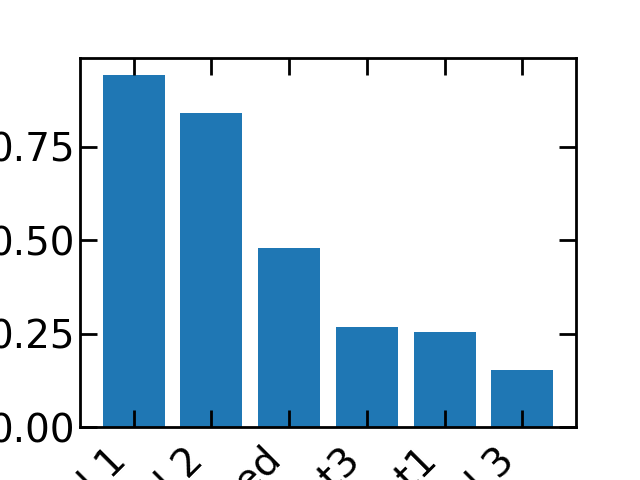

In [10]:
x = ax.plot.feature_importances.plot_feature_importance_by_feature(model).data['data'][0]['y']
y = ax.plot.feature_importances.plot_feature_importance_by_feature(model).data['data'][0]['x']
# invert the order
x = x[::-1]
y = y[::-1]
x_display_names = []
for xx in x:
    for p in mo.params:
        if p.name == xx:
            x_display_names.append(p.display_name)
            break
x = x_display_names
plt.figure()
plt.bar(x,y)
plt.ylabel('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

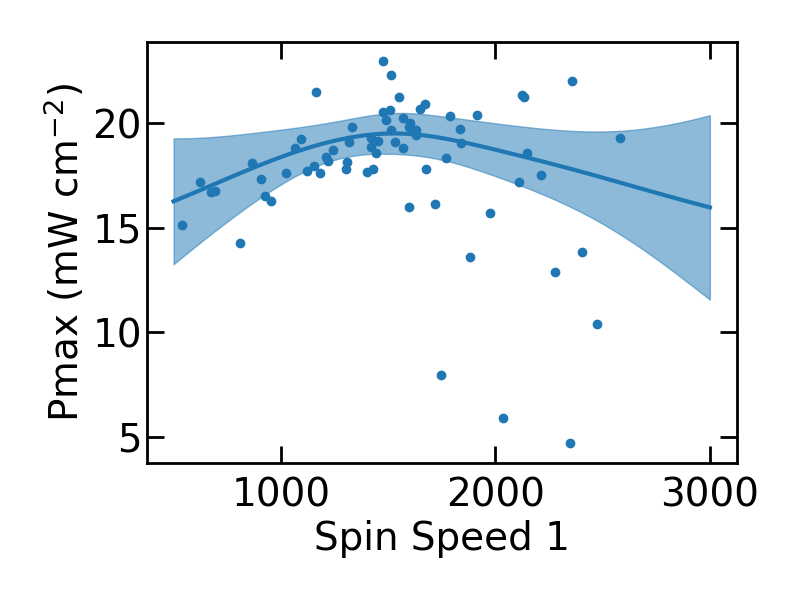

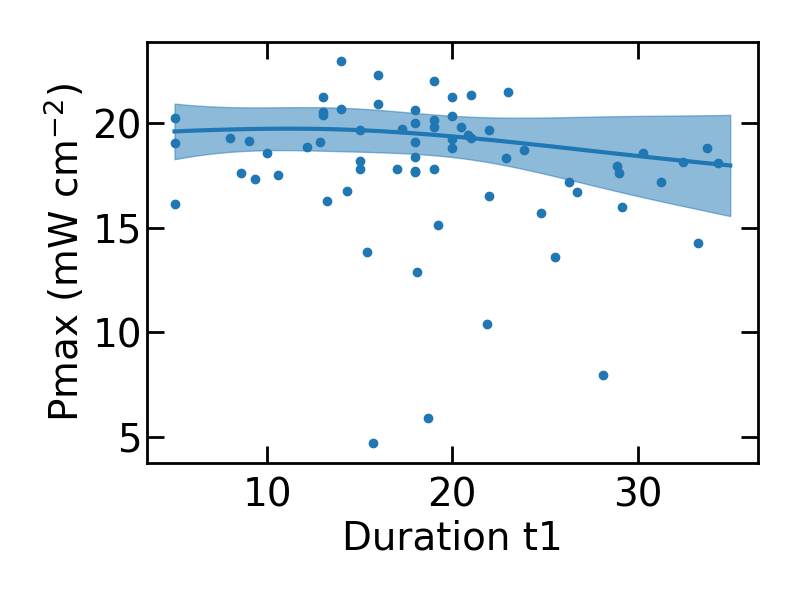

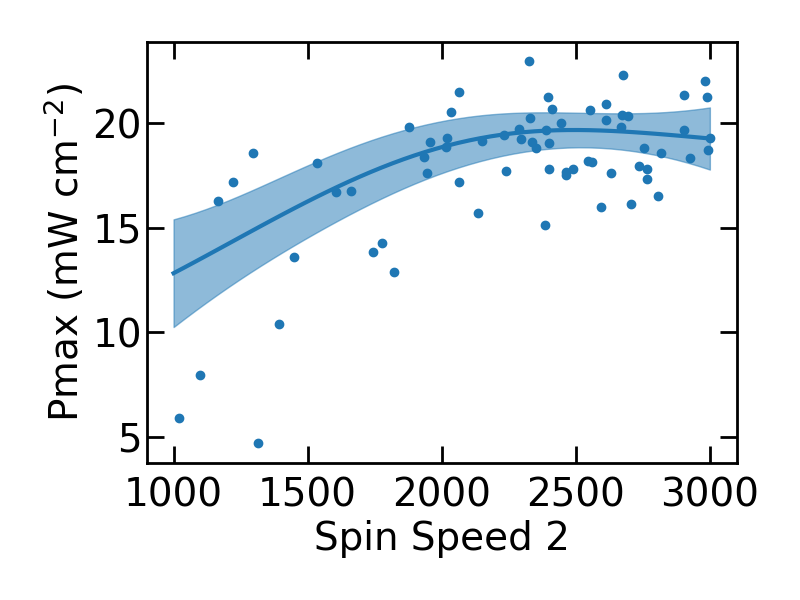

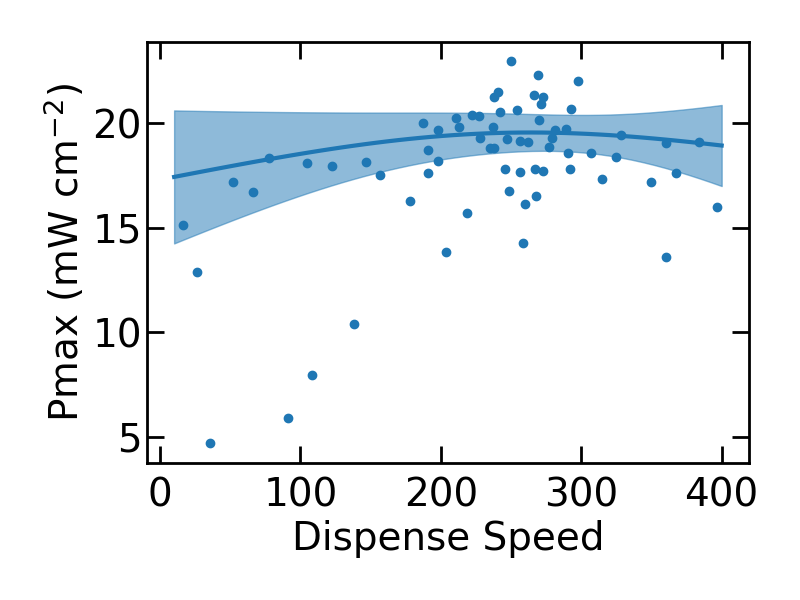

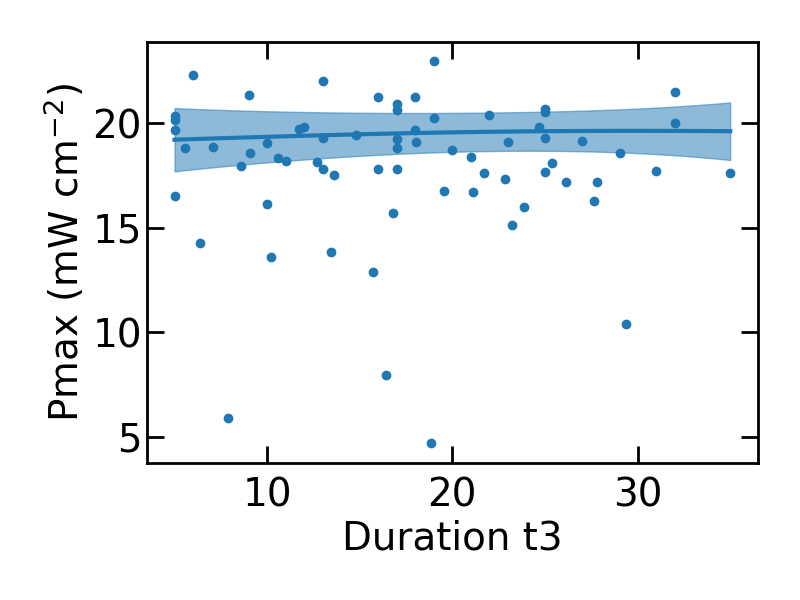

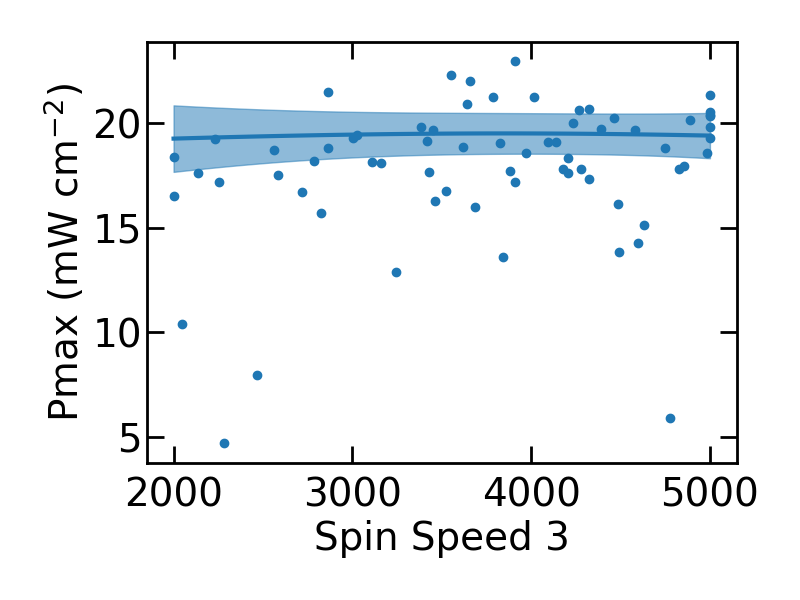

In [11]:

p_idx = 0
for p_idx in range(len(mo.params)):
    x = ax.plot.slice.plot_slice(model=model,param_name= mo.params[p_idx].name, metric_name= obj_type).data['data'][1]['x']
    y = ax.plot.slice.plot_slice(model=model,param_name=mo.params[p_idx].name, metric_name= obj_type).data['data'][1]['y']
    x1 = ax.plot.slice.plot_slice(model=model,param_name= mo.params[p_idx].name, metric_name= obj_type).data['data'][0]['x']
    y1 = ax.plot.slice.plot_slice(model=model,param_name= mo.params[p_idx].name, metric_name= obj_type).data['data'][0]['y']
    # cut x1 and y1 to the same length as x and y
    x_low = x1[:len(x)]
    y_low = y1[:len(y)]
    x_high = x1[len(x):]
    y_high = y1[len(y):][::-1]

    plt.figure(figsize=(8,6))
    plt.plot(x,y)
    # shade the area between the two curves
    plt.fill_between(x, y_low, y_high, color='C0', alpha=0.5)
    # plt.fill_between(x, y, y_high, color='gray', alpha=0.5)
    plt.plot(df_filtered[mo.params[p_idx].name],df_filtered[y_dimension],'C0o')
    plt.xlabel(mo.params[p_idx].display_name)
    plt.ylabel(y_dimension + ' (' + y_unit + ')')
    plt.tight_layout()
    plt.show()

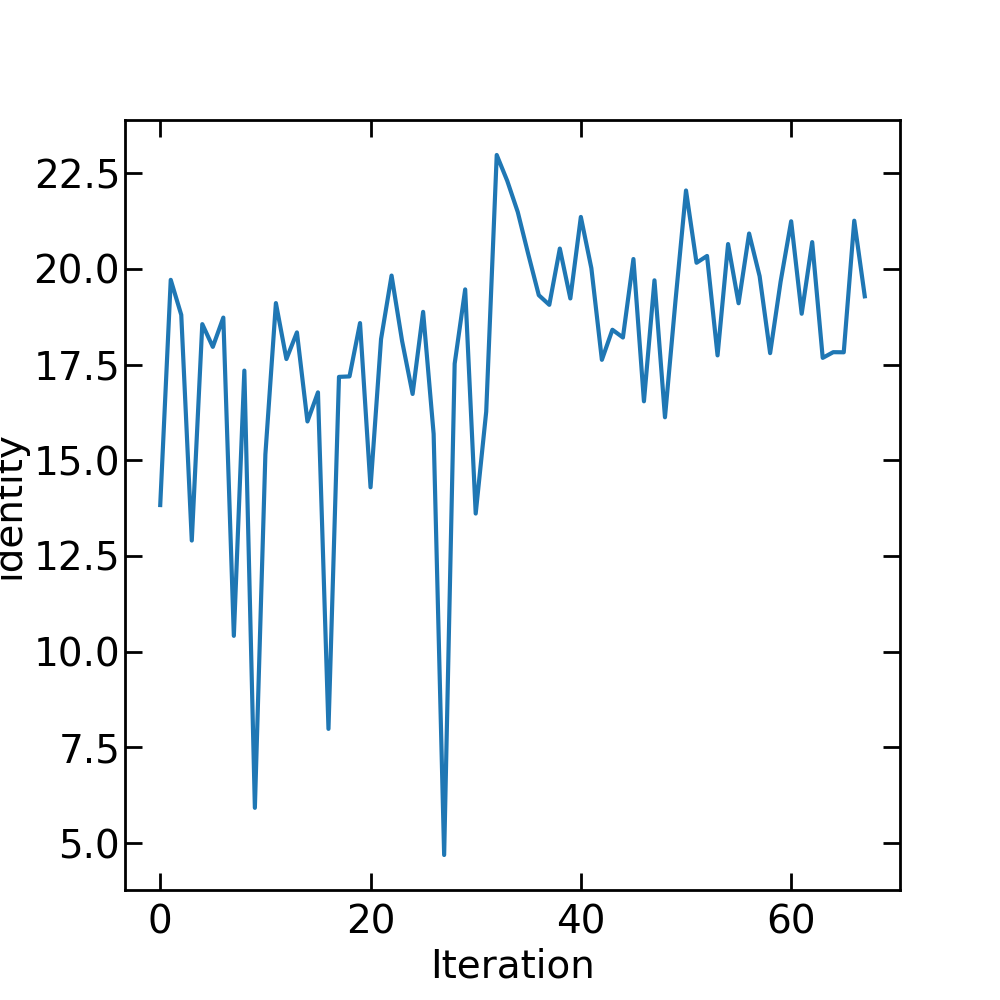

In [12]:
# Plot the Pareto front of the test problem
mo.plot_all_objectives(ax_client,logscale=False,figsize=(10,10))

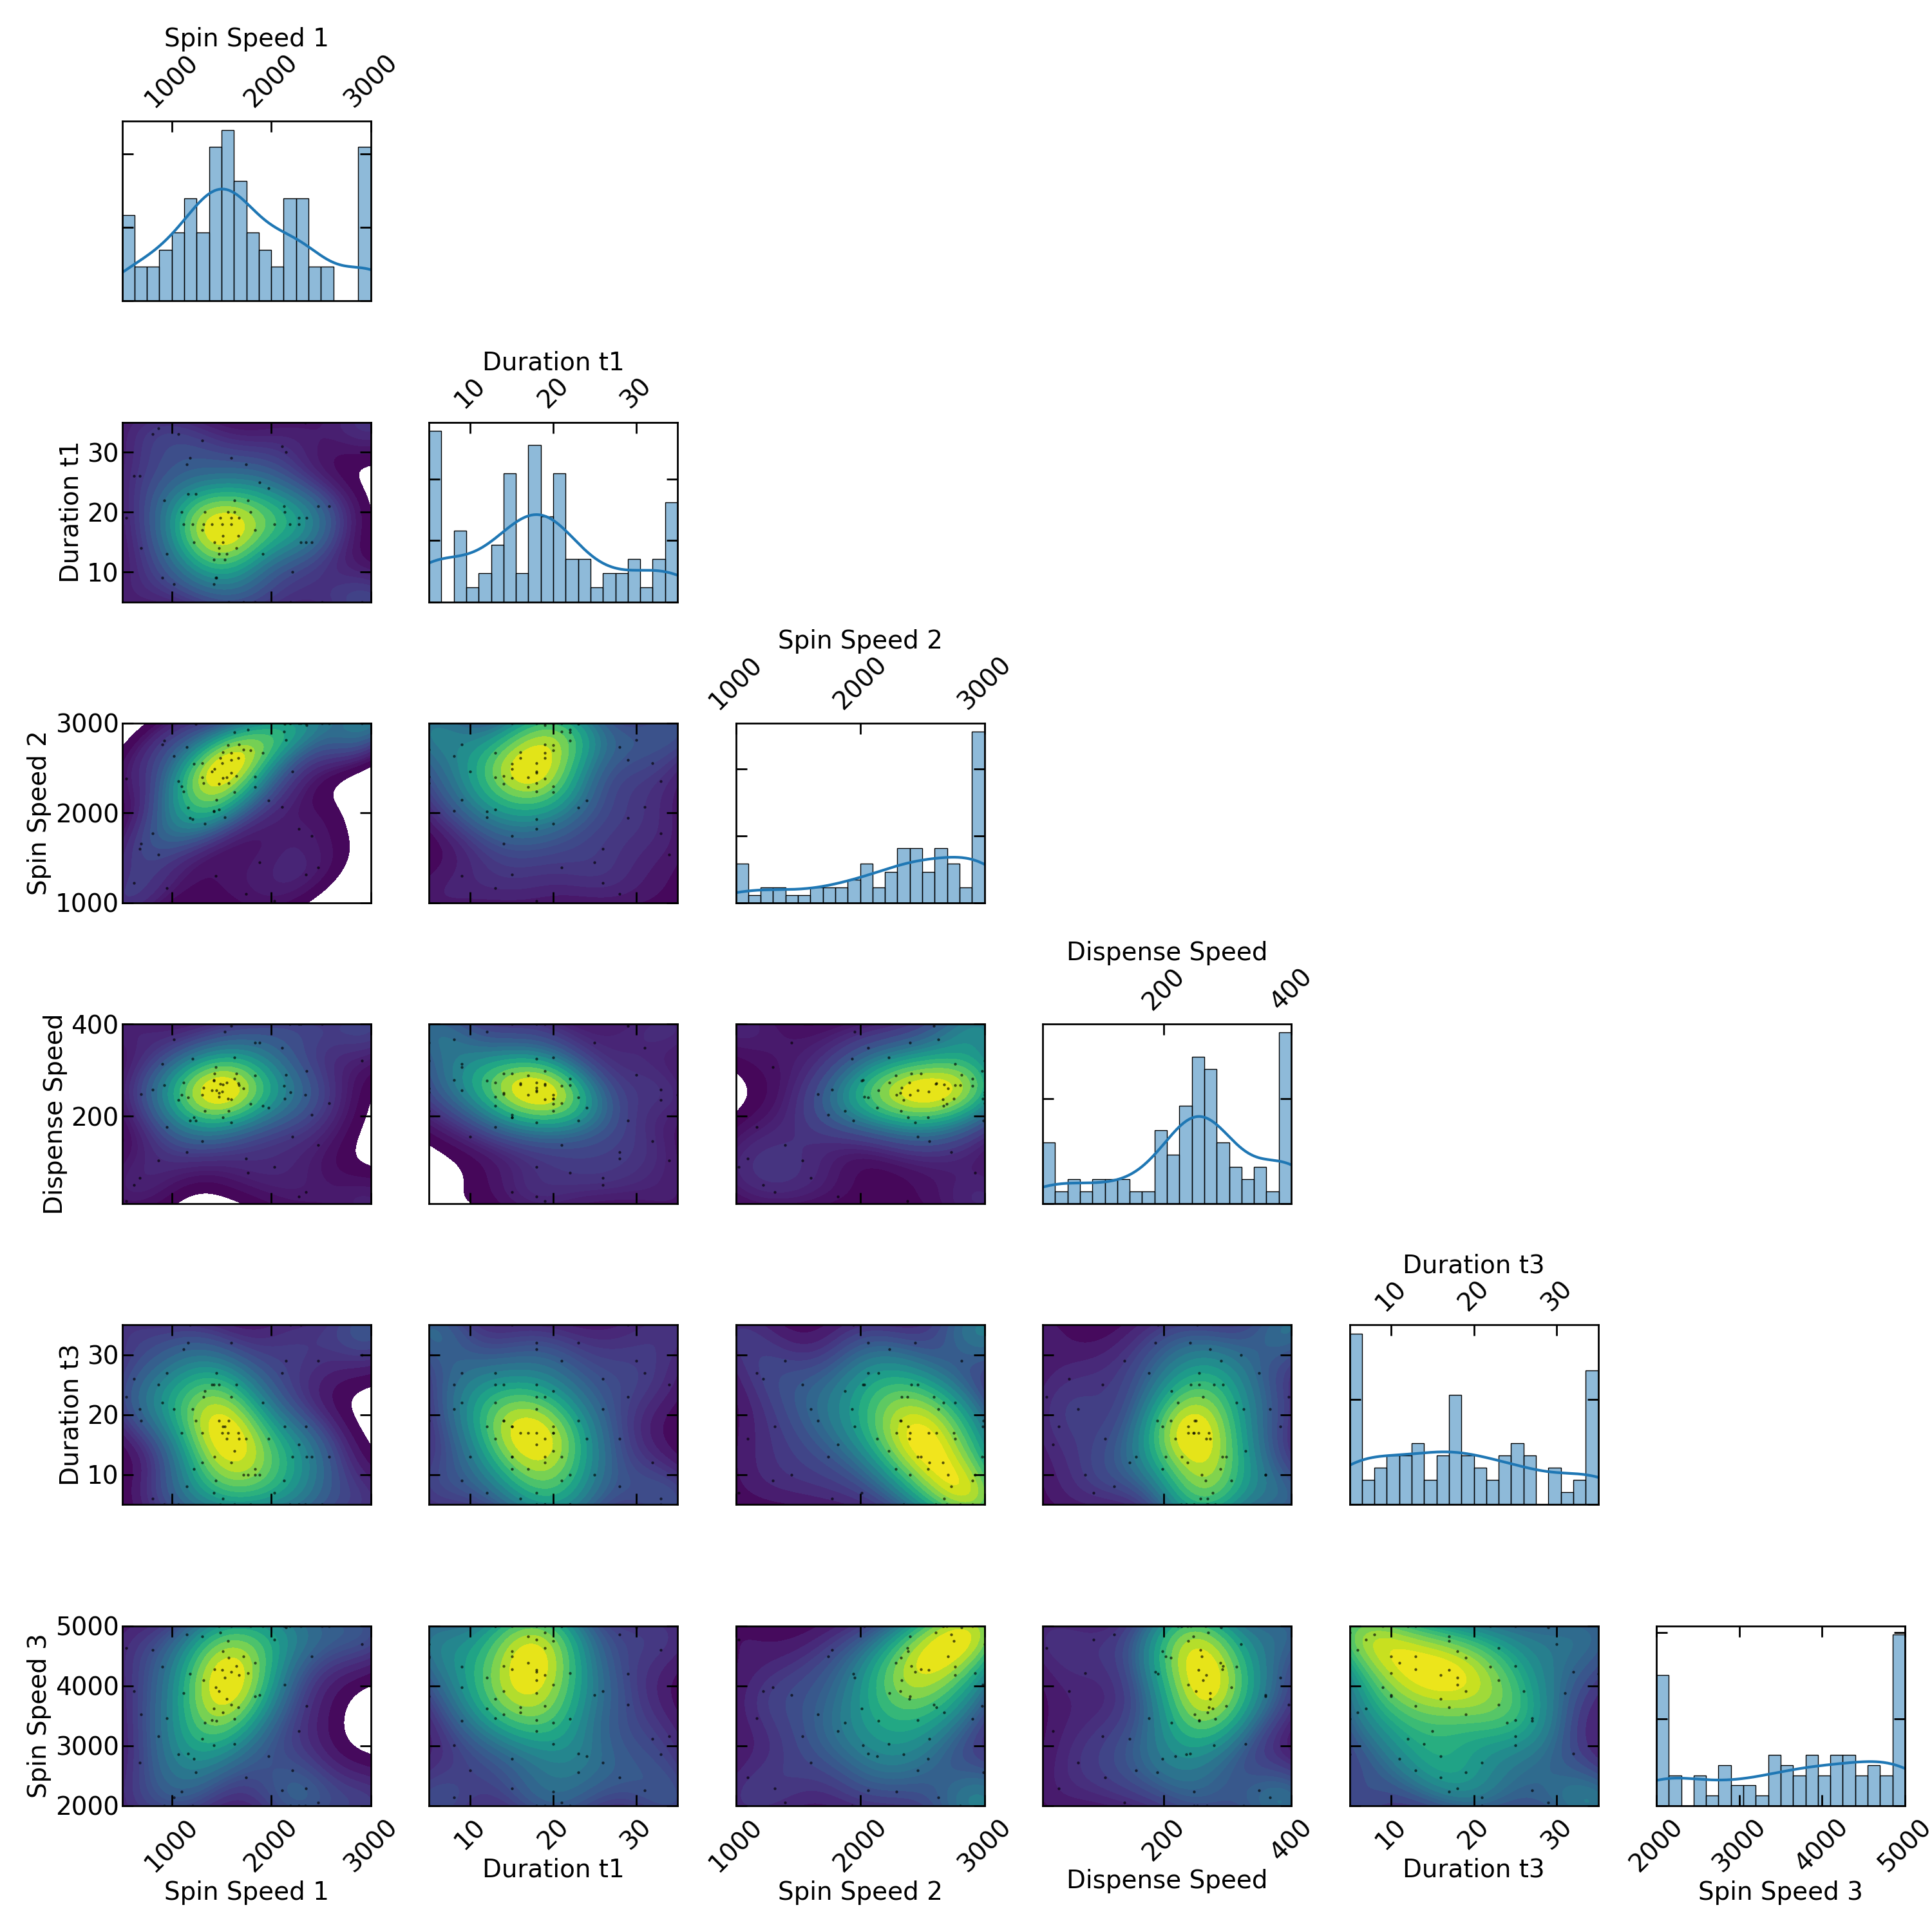

In [13]:
# Plot the density of points that were sampled during the optimization process
mo.plot_density(ax_client,figsize=(30,30))

In [14]:
# Plot the contour of the objective function for a given target

render(ax_client.get_contour_plot(param_x=params[0].name, param_y=params[-1].name, metric_name=obj_type))
render(ax_client.get_contour_plot(param_x=params[0].name, param_y=params[1].name, metric_name=obj_type))
render(ax_client.get_contour_plot(param_x=params[0].name, param_y=params[-2].name, metric_name=obj_type))



[INFO 09-02 11:34:09] ax.service.ax_client: Retrieving contour plot with parameter 'Spin_Speed_1' on X-axis and 'Spin_Speed_3' on Y-axis, for metric 'identity'. Remaining parameters are affixed to the middle of their range.


[INFO 09-02 11:34:10] ax.service.ax_client: Retrieving contour plot with parameter 'Spin_Speed_1' on X-axis and 'Duration_t1' on Y-axis, for metric 'identity'. Remaining parameters are affixed to the middle of their range.


[INFO 09-02 11:34:10] ax.service.ax_client: Retrieving contour plot with parameter 'Spin_Speed_1' on X-axis and 'Duration_t3' on Y-axis, for metric 'identity'. Remaining parameters are affixed to the middle of their range.


In [15]:
# Plot the slice (i.e., 1D projection) of the model along the a single dimension 
model = ax_client.generation_strategy.model
render(plot_slice(model, params[-1].name, obj_type))



In [16]:
# Plot the results of cross validation
from sklearn.metrics import r2_score
cv_results = cross_validate(model)

# calculate the r2
observed, predicted = [], []
for i in range(len(cv_results)):
    observed.append(cv_results[i].observed.data.means[0])
    predicted.append(cv_results[i].predicted.means[0])
r2 = r2_score(observed, predicted)
print(f'R2 = {r2}')
render(interact_cross_validation(cv_results))

R2 = 0.7398118992575277


In [17]:
# Interactive plot of the target during the optimization process
render(interact_fitted(model, rel=False, ))